In [1]:
import sys
SIM_PATH = "/home/luting/projects/sc_simulator"
sys.path.append(SIM_PATH) # simulator 项目的绝对路径
from simulator.hiererchical_simulator import *
from CME.CME_func import *
from figure_3a.curr_method_test import *
from figure_3a.tools import *
sys.path.append("/home/luting/projects/TAMER/MULE") # TAMER 项目的绝对路径
import mule as mu

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from collections import defaultdict

from anticor_features.anticor_features import get_anti_cor_genes
import singleCellHaystack as hs
import giniclust3 as gc
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.enrichment_scoring import calculate_escores
from SEMITONES.enrichment_scoring import permute
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import roc_curve, auc

/home/luting/.local/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Import MULE already


# 模拟数据

In [2]:
np.random.seed(2025)

Parsing xml tree file...
Generating alpha matrix...


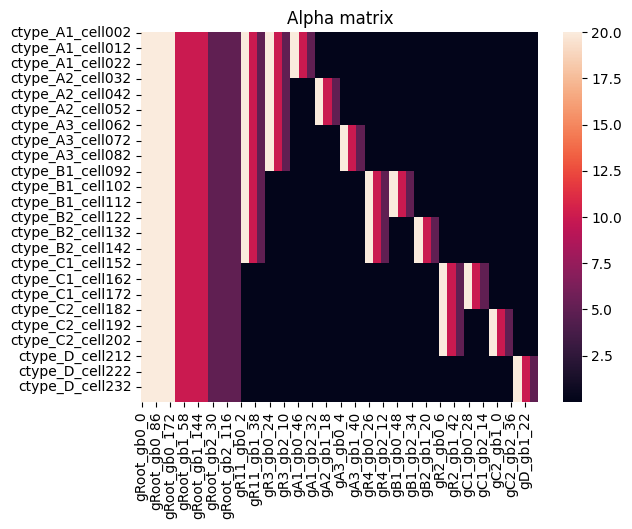

Sampling p's from Dirichlet distribution...
Sampling cell total UMIs from logNormal distribution...
A1 10 0.3
A2 10 0.3
A3 10 0.3
B1 10 0.3
B2 10 0.3
C1 10 0.3
C2 10 0.3
D 10 0.3
Sampling cells from multinomial distribution...


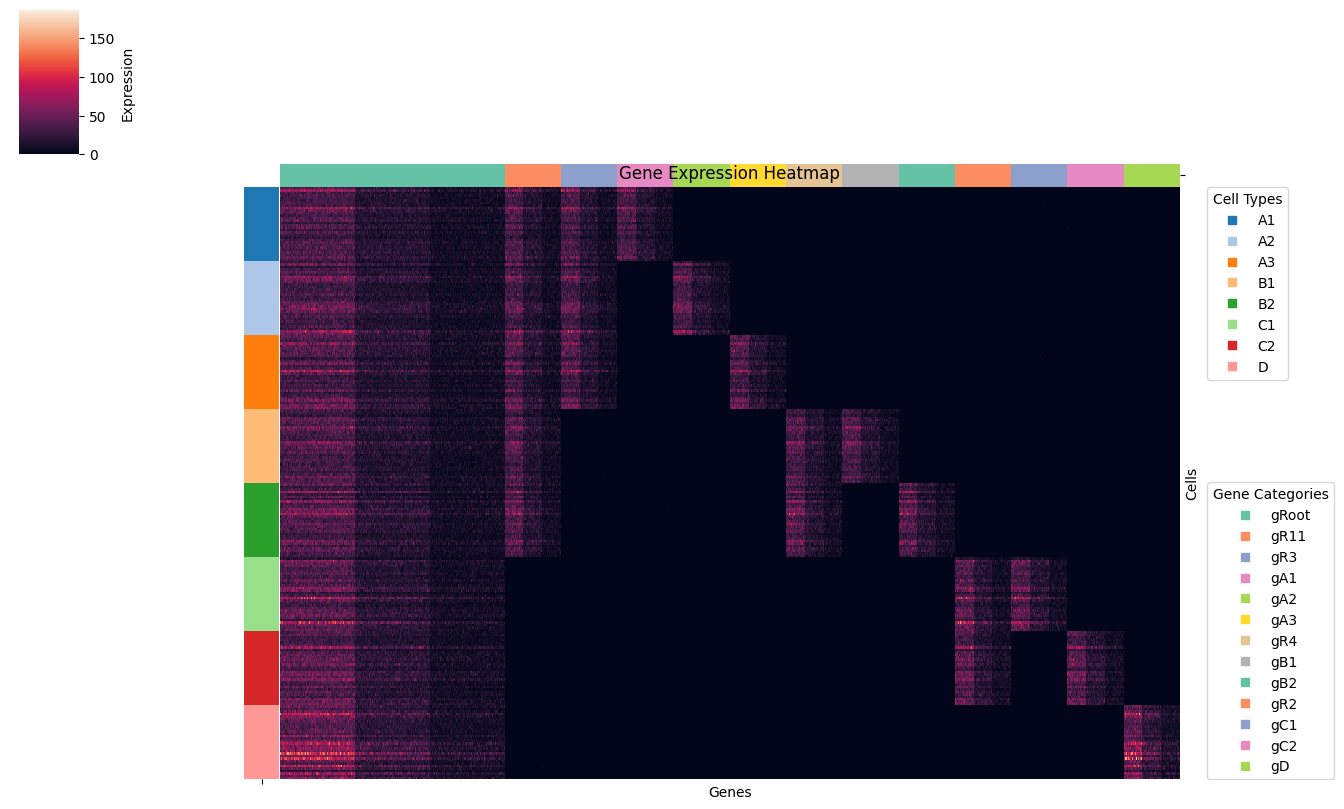

Saving anndata to: /home/luting/projects/sc_simulator/sim_data/adata/adata_1.h5ad


In [3]:
tree_dir = SIM_PATH + "/sim_data/trees"
data_dir = SIM_PATH + "/sim_data/adata"
tree_id = 1
data_df, adata = get_data_and_visualize(tree_id=tree_id, tree_dir=tree_dir, data_dir=data_dir)

In [4]:
entropy_score = imbalance_entropy(adata, key='cell_type')
print("Entropy score:", entropy_score)

Cell type counts: cell_type
A1    30
A2    30
A3    30
B1    30
B2    30
C1    30
C2    30
D     30
Name: count, dtype: int64
Entropy score: 2.0794415416798357


## 亚型

## Sunburnt 图

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd
import plotly.graph_objects as go

xml_file = SIM_PATH + f"/sim_data/trees/tree_{tree_id}.xml"
tree = ET.parse(xml_file)
root = tree.getroot()

data = []

def get_tree_height(node):
    """递归计算 celltype 的最大深度"""
    if node.tag != "celltype":
        return 0
    if not any(child.tag == "celltype" for child in node):
        return 1
    return 1 + max(get_tree_height(child) for child in node if child.tag == "celltype")

MAX_HEIGHT = max(get_tree_height(child) for child in root if child.tag == "celltype")

def parse_celltype(node, parent_name=None, current_depth=1):
    """递归解析 XML，只处理 <celltype>，并补齐虚拟节点"""
    if node.tag != "celltype":
        return

    name = node.attrib["name"]
    num_cells = int(node.attrib.get("num_cells", 0))

    entry = {
        "id": name,
        "parent": parent_name,
        "num_cells": num_cells,
        "is_virtual": False
    }
    data.append(entry)

    # 子 celltype 节点
    children = [child for child in node if child.tag == "celltype"]

    if children:
        for child in children:
            parse_celltype(child, parent_name=name, current_depth=current_depth+1)
    else:
        # 如果是叶子但没到最大深度，补虚拟节点
        depth = current_depth
        parent = name
        while depth < MAX_HEIGHT:
            virtual_name = f"{name}_v{depth}"
            data.append({
                "id": virtual_name,
                "parent": parent,
                "num_cells": num_cells,  # 沿用叶子数量
                "is_virtual": True
            })
            parent = virtual_name
            depth += 1

# 遍历根节点下的 celltype
for child in root:
    if child.tag == "celltype":
        parse_celltype(child, parent_name=None)

# 转 DataFrame
df = pd.DataFrame(data)

# Sunburst
fig = go.Figure(go.Sunburst(
    labels=df['id'],
    parents=df['parent'],
    values=df['num_cells'],
    branchvalues='total',
    hoverinfo='label+value+percent parent'
))
fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
fig.show()

print(df)

       id parent  num_cells  is_virtual
0    Root   None        240       False
1     R11   Root        150       False
2      R3    R11         90       False
3      A1     R3         30       False
4      A2     R3         30       False
5      A3     R3         30       False
6      R4    R11         60       False
7      B1     R4         30       False
8      B2     R4         30       False
9      R2   Root         60       False
10     C1     R2         30       False
11  C1_v3     C1         30        True
12     C2     R2         30       False
13  C2_v3     C2         30        True
14      D   Root         30       False
15   D_v2      D         30        True
16   D_v3   D_v2         30        True


# 跑方法

## MULE

In [41]:
# 处理数据
def mule_process(adata, opposite_graph_threshold = 0.8, subgraph_threshold=3, merge_threshold=40):
    adata = adata.copy()
    # sc.pp.normalize_total(adata, target_sum=1e6)
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)
    mu.pre_process.hvg(adata)
    # sns.heatmap(adata.X)
    # adata = adata[:,adata.var['highly_variable'] == True]
    mu.tax.mutually_exclusively_detect_CME(adata)
    mu.vis.polar_score(adata)

    mu.tax.build_opposite_graph(adata, threshold = opposite_graph_threshold)
    mu.vis.graph_degree(adata)

    mu.tax.get_subgraph(adata,threshold=subgraph_threshold)
    mu.vis.merge_strategy(adata)

    mu.tax.bipartite_embedding_perm_fast(adata,merge_threshold=merge_threshold)
    mu.vis.oppo_filter_graph(adata)
    mu.vis.mode_graph(adata)

    mu.tax.build_taxonomy_tree(adata)
    mu.tax.cal_scpurity_cme_parallel(adata)

    mu.tax.mule_umap(adata, ['mode 0', 'mode 1'])
    sc.tl.score_genes(adata, gene_list=adata.uns['mule']['mode info']['mode 1'])
    sc.pl.embedding(adata, basis='X_umap_mule', color = 'score')

    tree = mu.vis.plot_taxonomy_tree(adata)
    Image(tree.create_png())

    return adata

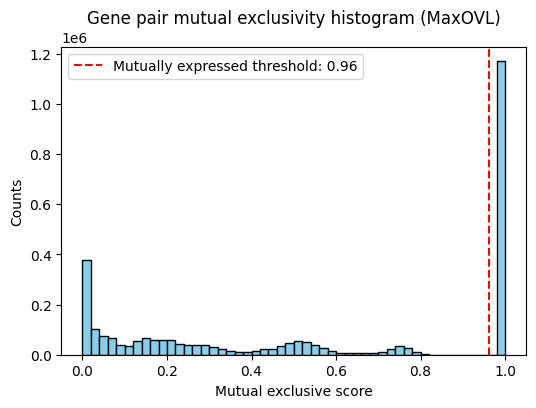

Build mutually exclusive gene graph
Calculate original graph degree


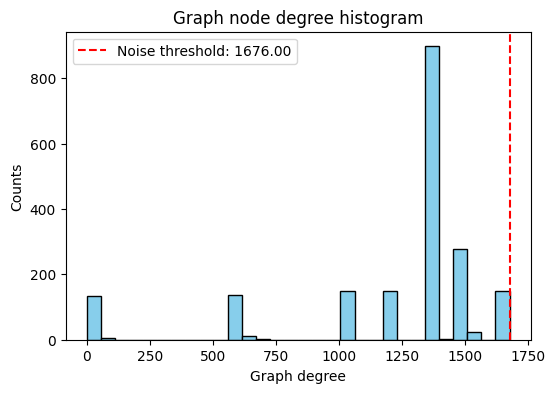

Filter low-degree nodes (denoise genes)


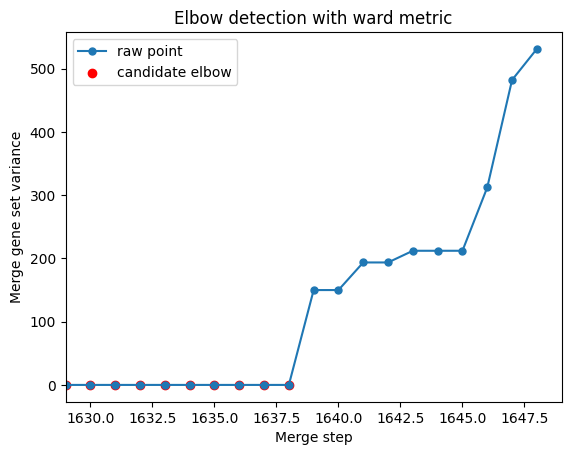

Linkage info (last 20 steps):
1629      0.000000
1630      0.000000
1631      0.000000
1632      0.000000
1633      0.000000
1634      0.000000
1635      0.000000
1636      0.000000
1637      0.000000
1638      0.000000
1639    150.000000
1640    150.000000
1641    193.649167
1642    193.649167
1643    212.132034
1644    212.132034
1645    212.132034
1646    312.249900
1647    482.182538
1648    531.293447
Name: 2, dtype: float64
plot the opposite filter graph


KeyboardInterrupt: 

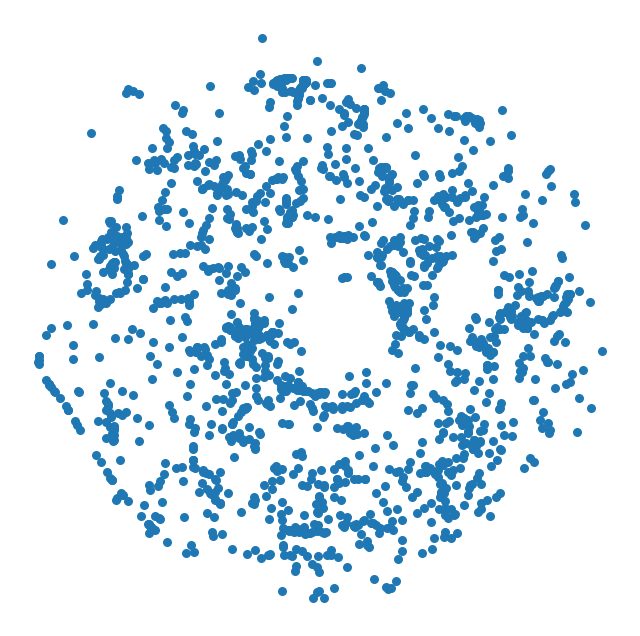

In [42]:
adata_mule = mule_process(adata, opposite_graph_threshold = 0.8, subgraph_threshold=1000, merge_threshold=175)

CME_score_df = adata_mule.uns['mule']['opposite score']

result_df = adata_mule.uns['mule']['graph_degree']
result_df.index = result_df['gene']

mule_genes = []
for mode in adata_mule.uns['mule']['mode info']:
    mule_genes = mule_genes + adata_mule.uns['mule']['mode info'][mode]
mule_result = dict()
mule_result['genes'] = []
mule_result['scores'] = []
for gene in result_df.index:
    if gene in mule_genes:
        mule_result['genes'] = mule_result['genes'] + [gene]
        mule_result['scores'] = mule_result['scores'] + [result_df.loc[gene, 'degree']]

<Axes: >

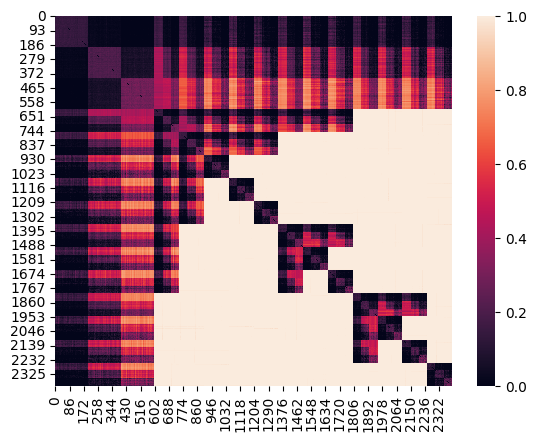

In [47]:
sns.heatmap(CME(adata.X.T))

<Axes: >

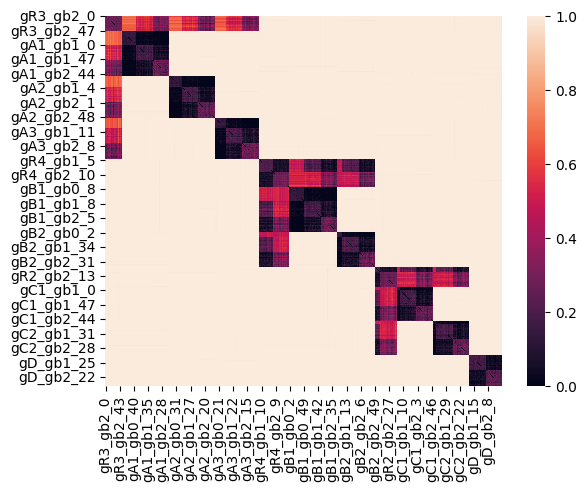

In [39]:
sns.heatmap(adata_mule.uns['mule']['opposite score df'])

## Anti-Corr

In [30]:
def run_anticorrelation(adata):
    adata_copy = adata.copy()
    sc.pp.normalize_total(adata_copy)
    
    anti_cor_table = get_anti_cor_genes(
        adata_copy.X.T,
        adata_copy.var.index.tolist(),
        species="hsapiens",
        pre_remove_pathways=[],
        # FPR=0.5,
        # FDR=0.5
    )
    selected_table = anti_cor_table[anti_cor_table["selected"]==True]
    return {
        "genes": selected_table.index.to_numpy(),
        "scores": -np.array(anti_cor_table['FDR'].to_list())
    }

## GiniClust

In [9]:
def run_gini(adata):
    adata_copy = adata.copy()
    sc.pp.log1p(adata_copy)
    gc.gini.calGini(adata_copy, min_gini_value=0.1, neighbors=3, p_value=0.05)
    adata_gini = adata_copy[:, np.where(adata_copy.var['gini'] == True)[0]].copy()
    return {
        "genes": adata_gini.var.index.to_numpy(),
        # "scores": adata_copy.var['gini_value'].values
    }

In [10]:
gini_res = run_gini(adata)
gini_res

Gene number is 2400
Cell number is actually240
sigGiniGene: {}
sigGiniGene: {'gRoot_gb2_0': 0.1491085460976459, 'gRoot_gb2_1': 0.1541841417927338, 'gRoot_gb2_2': 0.1684544066907533, 'gRoot_gb2_3': 0.15239272393756562, 'gRoot_gb2_4': 0.15364742918777222, 'gRoot_gb2_5': 0.1618058398792218, 'gRoot_gb2_6': 0.13584397686928434, 'gRoot_gb2_7': 0.15241974415293688, 'gRoot_gb2_8': 0.15660537415143083, 'gRoot_gb2_9': 0.15879481708696433, 'gRoot_gb2_10': 0.16025008903844512, 'gRoot_gb2_12': 0.151793056009177, 'gRoot_gb2_14': 0.15191299486341517, 'gRoot_gb2_17': 0.15622253249196277, 'gRoot_gb2_18': 0.15493706262638196, 'gRoot_gb2_19': 0.16024115548924203, 'gRoot_gb2_20': 0.1547878246632088, 'gRoot_gb2_21': 0.1395154872794453, 'gRoot_gb2_22': 0.14354528860585536, 'gRoot_gb2_23': 0.16976655844491298, 'gRoot_gb2_24': 0.15692337062267567, 'gRoot_gb2_26': 0.15856759101014203, 'gRoot_gb2_28': 0.14760445835372085, 'gRoot_gb2_29': 0.1502713872976917, 'gRoot_gb2_31': 0.15675698441104746, 'gRoot_gb2_32': 0

{'genes': array(['gRoot_gb2_0', 'gRoot_gb2_1', 'gRoot_gb2_2', 'gRoot_gb2_3',
        'gRoot_gb2_4', 'gRoot_gb2_5', 'gRoot_gb2_6', 'gRoot_gb2_7',
        'gRoot_gb2_8', 'gRoot_gb2_9', 'gRoot_gb2_10', 'gRoot_gb2_12',
        'gRoot_gb2_14', 'gRoot_gb2_17', 'gRoot_gb2_18', 'gRoot_gb2_19',
        'gRoot_gb2_20', 'gRoot_gb2_21', 'gRoot_gb2_22', 'gRoot_gb2_23',
        'gRoot_gb2_24', 'gRoot_gb2_26', 'gRoot_gb2_28', 'gRoot_gb2_29',
        'gRoot_gb2_31', 'gRoot_gb2_32', 'gRoot_gb2_33', 'gRoot_gb2_34',
        'gRoot_gb2_35', 'gRoot_gb2_37', 'gRoot_gb2_38', 'gRoot_gb2_39',
        'gRoot_gb2_40', 'gRoot_gb2_41', 'gRoot_gb2_43', 'gRoot_gb2_44',
        'gRoot_gb2_45', 'gRoot_gb2_47', 'gRoot_gb2_48', 'gRoot_gb2_49',
        'gRoot_gb2_52', 'gRoot_gb2_53', 'gRoot_gb2_54', 'gRoot_gb2_55',
        'gRoot_gb2_56', 'gRoot_gb2_57', 'gRoot_gb2_58', 'gRoot_gb2_60',
        'gRoot_gb2_61', 'gRoot_gb2_63', 'gRoot_gb2_65', 'gRoot_gb2_66',
        'gRoot_gb2_67', 'gRoot_gb2_68', 'gRoot_gb2_69', 'gRoot_gb

## scHayStack

In [11]:
def dimension_reduce(adata):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
    return adata

In [12]:
def run_haystack(adata):
    adata_hs = adata.copy()
    adata_hs.layers["counts"] = adata_hs.X.copy()
    sc.pp.normalize_total(adata_hs)
    sc.pp.log1p(adata_hs)
    adata_hs = dimension_reduce(adata_hs)
    res = hs.haystack(adata_hs, coord="X_pca")
    adata_hs = adata_hs[:,res.top_features(n=120)['gene'].tolist()].copy()
    print(adata_hs)
    return {
        "genes": adata_hs.var_names.to_numpy(),
        "scores": -res.result['pval_adj'].values
    }

In [29]:
for key in results:
    print(key, len(results[key]['scores']))

Anti-correlation 1679
Haystack 2400
Semitones 2400
DubStepR 593
MULE 735


## semitones

In [13]:
def run_semitones(adata):
    """运行 Semitones 方法"""
    adata_copy = adata.copy()
    adata_copy.layers["counts"] = adata_copy.X.copy()
    sc.pp.normalize_total(adata_copy)
    sc.pp.log1p(adata_copy)
    adata_copy = dimension_reduce(adata_copy)

    S = pairwise_kernels(adata_copy.obsm['X_pca'], metric="rbf", gamma=8.6e-4)
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(
        X=adata_copy.obsm['X_pca'],
        n_ret=17,
        start=start,
        metric_params={"gamma": 8.6e-4}
    )
    S = pairwise_similarities(adata_copy.obsm['X_pca'], query=dd_rcells, metric_params={"gamma": 8.6e-4})

    escores = calculate_escores(adata_copy.X, query=dd_rcells, S=S)

    P = permute(adata_copy.X)
    pscores = calculate_escores(P, query=dd_rcells, S=S)
    interval = sig_interval(pscores, n_sds=8)
    sigdict = sig_dictionary(escores, interval)
    subset = list({x for v in sigdict.values() for x in v})
    adata_semi = adata_copy[:, subset].copy()
    print(adata_semi)
    return {
        "genes": adata_semi.var.index.to_numpy(),
        "scores": escores.max(axis=1)
    }

## DubStepR

In [14]:
def run_dubstepr(adata):
    data_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    dubstepr_genes, dubstepr_zscores = analyze_gene_correlations(data_df, n_bins=15)
    return {
        "genes": dubstepr_genes,
        "scores": dubstepr_zscores
    }
# print(f"Found {len(dubstepr_genes)} genes with high correlation range")
# print("Selected genes:", dubstepr_genes)  # Print first 10 genes
# plot_cell_gene_heatmap(data_df, selected_genes, title='Cell-Gene Expression Heatmap\n(DubStepR Selected Genes in Yellow)')

## 可用方法列表

In [15]:
METHODS = {
    "Anti-correlation": run_anticorrelation,
    "Gini": run_gini,
    "Haystack": run_haystack,
    "Semitones": run_semitones,
    "DubStepR": run_dubstepr
}

In [16]:
def evaluate_methods(adata, method_names):
    """
    输入要运行的方法名称列表，输出 {方法名: {"genes": ..., "scores": ...}}
    """
    results = {}
    for name in method_names:
        if name not in METHODS:
            raise ValueError(f"方法 {name} 不在支持列表中: {list(METHODS.keys())}")
        print(f"Running {name} ...")
        results[name] = METHODS[name](adata)
    return results

In [17]:
method_list = ["Anti-correlation", "Haystack", "Semitones", "DubStepR"]
results = evaluate_methods(adata, method_list)
results['MULE'] = mule_result

Running Anti-correlation ...
found 33.364086784 free Gb in /tmp
get_all_remove_genes
240 12
min_express_n 12
get_n_expressed


pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  2400
rewriting the filtered dataset
/tmp/exprs.hdf5
total_vars: 2400
making the hdf5 spearman output file
/tmp/spearman.hdf5
Getting the Spearman correlations
total_vars 2400
empirically determined Cneg cutoff: -0.19562878465184486  for FPR of: 0.001
empirically determined Cpos cutoff: 0.24172529394146697  for FPR of: 0.001
get_real_spear
[0, 2400]
working on 0 2400 vs 0 2400
Running Haystack ...
> starting haystack ...
> entering array method ...
> scaling coordinates ...
> calculating feature stds ...
> calculating grid points ...
> calculating distance to cells ...
> calculating densities ...
> calculating Q dist ...
> calculating KLD for 2400 features ...


100%|██████████| 2400/2400 [00:00<00:00, 16949.19it/s]


> calculating feature's CV ...
> selecting genes to randomize ...
> calculating randomized KLD ...


100%|██████████| 100/100 [00:00<00:00, 176.90it/s]


> calculating P values ...
> done.
AnnData object with n_obs × n_vars = 240 × 120
    obs: 'cell_type'
    uns: 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
Running Semitones ...
Start enrichment scoring
Enrichment scoring complete
Start enrichment scoring
Enrichment scoring complete
AnnData object with n_obs × n_vars = 240 × 373
    obs: 'cell_type'
    uns: 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
Running DubStepR ...


# 对比

## Ground Truth

In [ ]:
all_genes = [gene for gene in data_df.columns]
all_markers = [gene for gene in data_df.columns if not gene.startswith("gRoot")]
pattern = re.compile(r"^g(" + "|".join(adata.obs['cell_type'].value_counts().index.categories) + r")")
subtype_markers = [gene for gene in data_df.columns if pattern.match(gene)]

# 选择使用什么 marker
marker_type = int(input("请输入想使用大类/亚型 marker（大类输入 0，亚型输入 1）："))
if marker_type==0:
    markers_used = all_markers
else:
    markers_used = subtype_markers

## 雷达图

In [19]:
# 提取基因类别（属于什么 marker）
def extract_gene_category(gene_name):
        match = gene_name.split("_")
        if match:
            return match[0]
        return "Unknown"

gene_categories = [extract_gene_category(gene) for gene in markers_used]
gene_dict = defaultdict(list)
for category, gene_name in zip(gene_categories, markers_used):
    gene_dict[category].append(gene_name)

In [20]:
def split_dict_by_group(data):
    result = defaultdict(lambda: defaultdict(list))
    
    for key, values in data.items():
        for v in values:
            parts = v.split("_")
            if len(parts) > 1:
                group = parts[1]   # 比如 "gb0"
                result[group][key].append(v)
    
    return dict(result)

classed_dict = split_dict_by_group(gene_dict)
print("不同层：", classed_dict.keys())

不同层： dict_keys(['gb0', 'gb1', 'gb2'])


In [21]:
def radar_chart_from_method_results(method_results, gene_dict, adatas=None, method_colors=None):
    """
    画雷达图，每个角表示一个基因类别，值表示该方法在该类别中找出的基因比例。
    
    参数：
        method_results: dict
            每个 key 是方法名，每个 value 是 {'genes': [...], 'scores': [...]} 的 dict
        gene_dict: dict
            每个 key 是基因类别，value 是该类别的基因列表
        adatas: list of AnnData, optional
            每个方法对应的 AnnData（如果要根据实际选出的基因计算敏感性）
            如果 None，则直接用 method_results['genes'] 计算
        method_colors: list, optional
            每个方法的颜色
    """
    import matplotlib.pyplot as plt

    methods = list(method_results.keys())
    categories = list(gene_dict.keys())
    
    # 默认颜色
    if method_colors is None:
        default_colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e', '#17becf', '#8c564b']
        method_colors = [default_colors[i % len(default_colors)] for i in range(len(methods))]

    # 计算每个方法在每个类别的敏感性
    sensitivity_results = {}
    for i, method in enumerate(methods):
        method_genes = set(method_results[method]['genes'])
        sensitivity = []
        for category, gene_list in gene_dict.items():
            gene_list_set = set(gene_list)
            tp = len(gene_list_set & method_genes)
            num = len(gene_list_set)
            sensitivity.append(tp / num if num > 0 else 0)
        sensitivity_results[method] = sensitivity

    # 画雷达图
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 闭合

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i, method in enumerate(methods):
        values = sensitivity_results[method] + [sensitivity_results[method][0]]
        ax.plot(angles, values, 'o-', linewidth=1.5, label=method, color=method_colors[i], markersize=6)
        ax.fill(angles, values, alpha=0.05, color=method_colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_rlabel_position(30)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)])
    ax.grid(alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.title("Gene Category Sensitivity Radar Chart", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


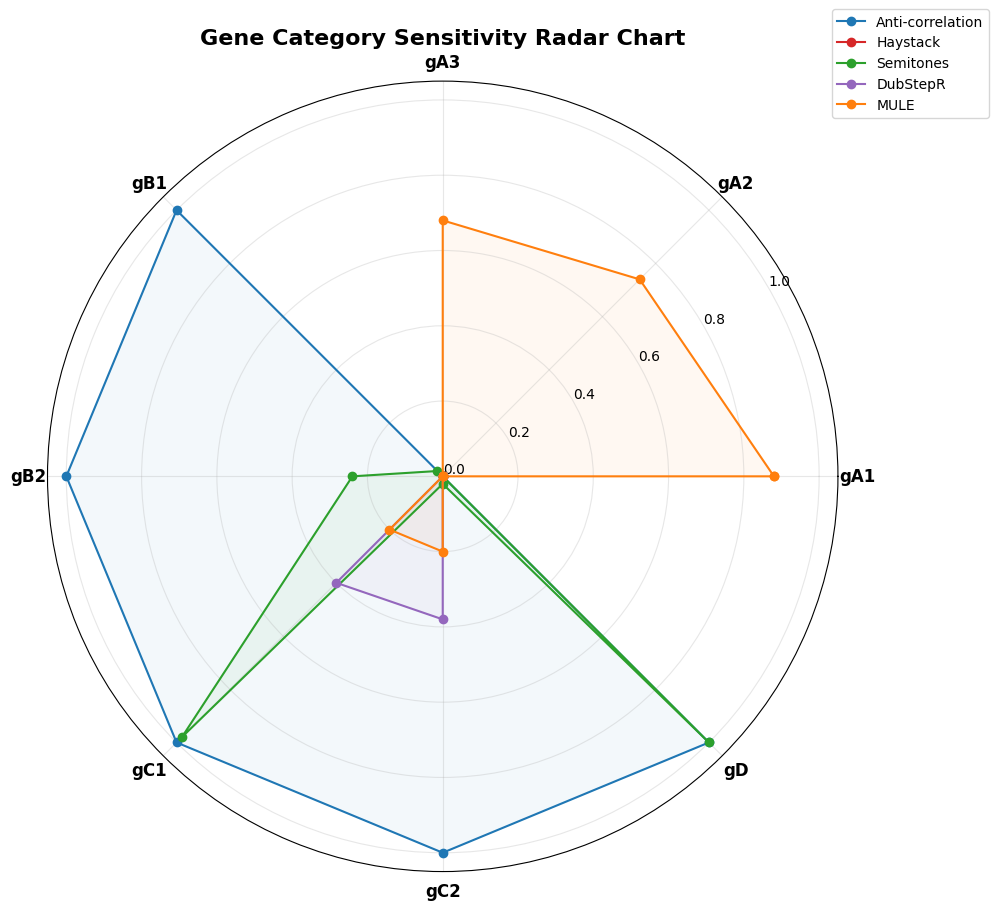

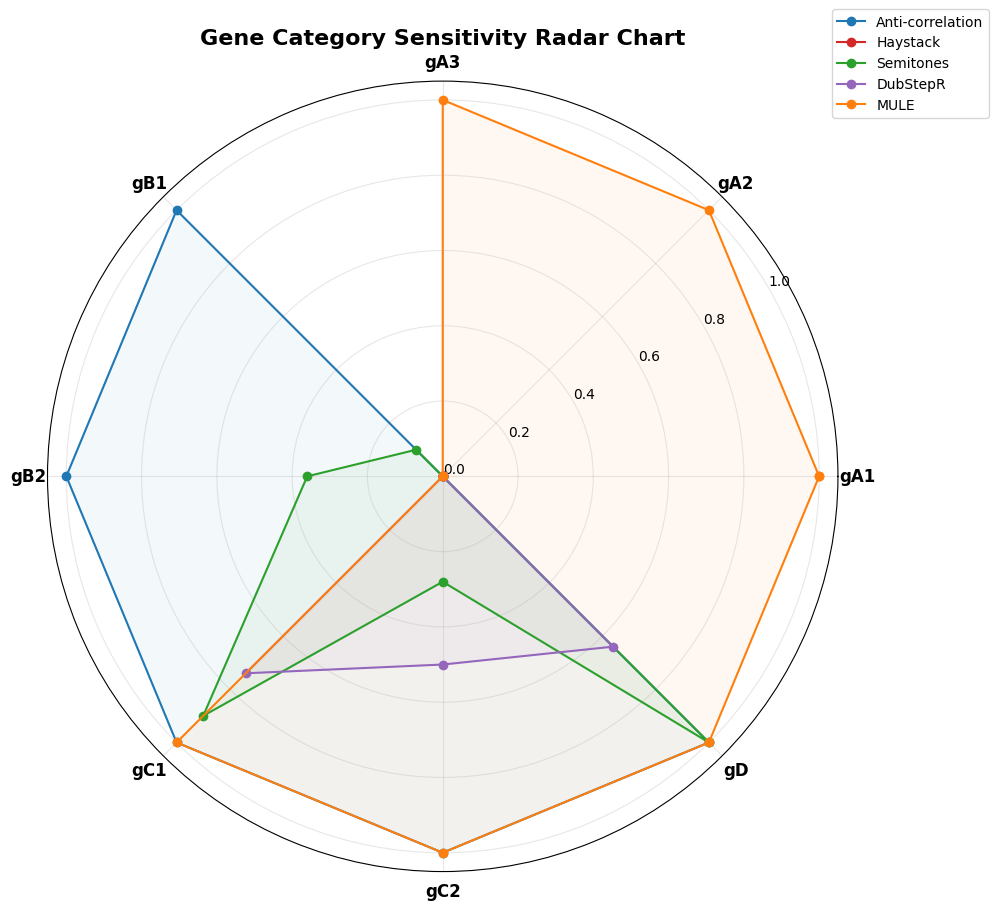

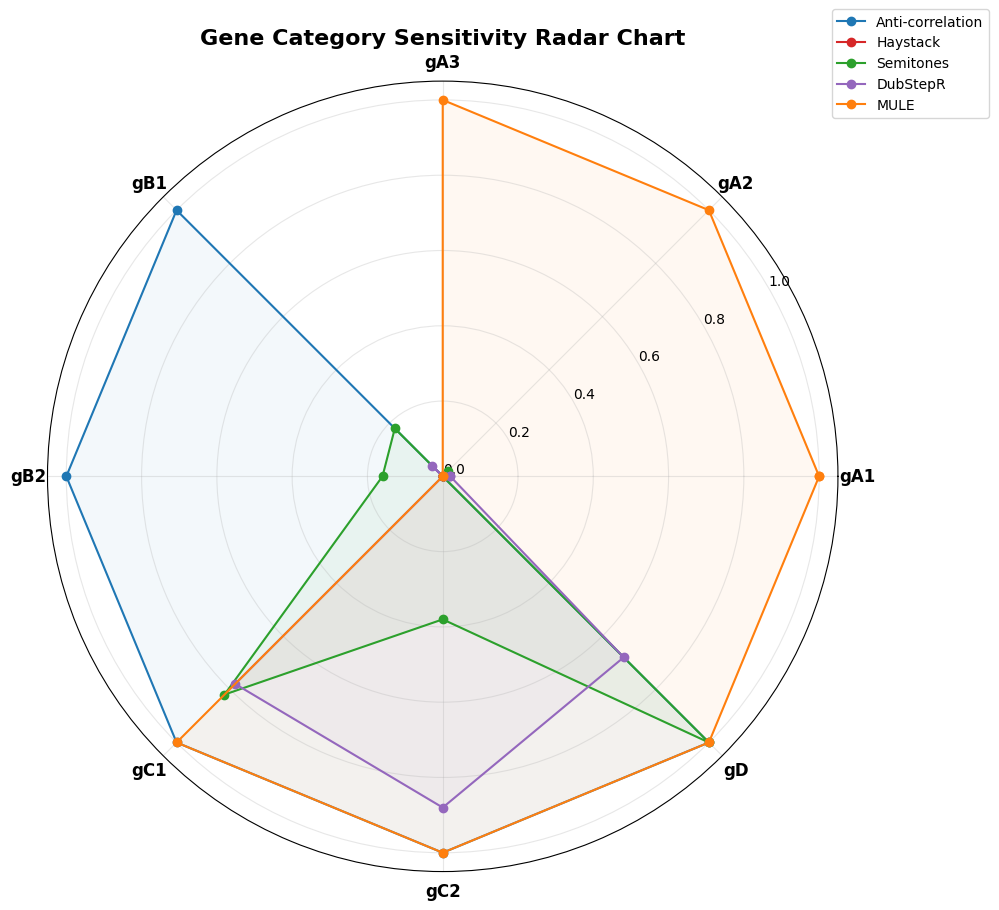

In [22]:
# method_list = ["Anti-correlation", "DubStepR"]
# results = evaluate_methods(adata, method_list)
# results['MULE'] = mule_result
for gene_strength in classed_dict:
    radar_chart_from_method_results(results, classed_dict[gene_strength])

## ROC 图

In [23]:
def ROC(label, method_results):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    colors = ['darkorange', 'green', 'red', 'blue', 'purple', 'brown']
    names = list(method_results.keys())

    plt.figure(figsize=(8, 8))

    for i, name in enumerate(names):
        res = method_results[name]
        genes = res["genes"]
        scores = res["scores"]

        # 内部排序，按 score 降序排列基因
        sorted_indices = np.argsort(scores)[::-1]
        sorted_genes = [genes[j] for j in sorted_indices]
        sorted_scores = [scores[j] for j in sorted_indices]

        # 创建与 label 对齐的分数数组
        gene_to_score = dict(zip(sorted_genes, sorted_scores))
        scores_array = np.array([gene_to_score.get(g, 0) for g in adata.var_names])

        # 计算 ROC
        fpr, tpr, _ = roc_curve(label, scores_array)
        roc_auc = auc(fpr, tpr)

        # 画 ROC 曲线
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f'{name} (AUC = {roc_auc:.3f})')

        # 打印 AUC
        print(f"{name}: AUC = {roc_auc:.4f}")

    # 图形美化
    plt.axis('off')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.legend(loc='lower right', frameon=True, fontsize=10, edgecolor='black')
    plt.tight_layout()
    plt.show()

Anti-correlation: AUC = 0.4184


IndexError: index 717 is out of bounds for axis 0 with size 120

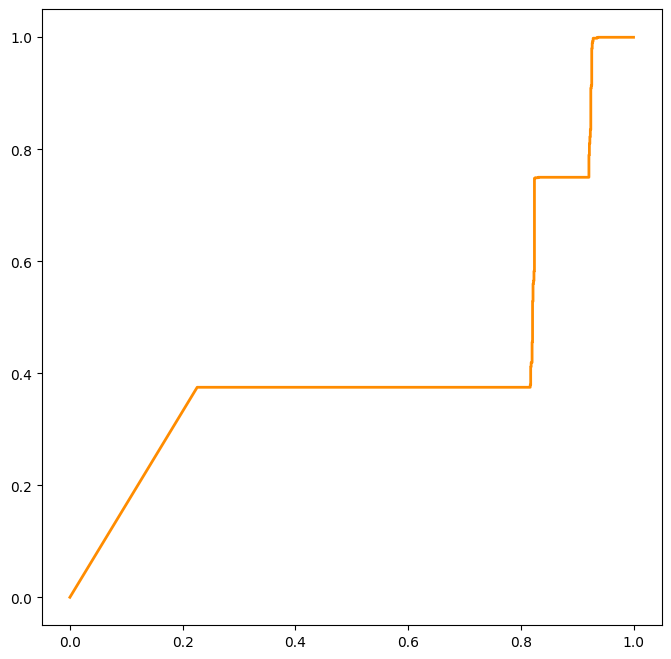

In [24]:
# method_list = ["Anti-correlation"]
# results = evaluate_methods(adata, method_list)
# results['MULE'] = mule_result

# ROC
label = [1 if g in markers_used else 0 for g in adata.var_names]

auc_dict = ROC(label, results)

## UMAP

In [34]:
def plot_umap_by_method(adata, method_results, random_state=0):
    """
    为每个方法选出的基因绘制 UMAP。
    
    参数：
        adata: AnnData
            原始数据
        method_results: dict
            每个方法名对应 {'genes': [...], 'scores': [...]}
        random_state: int
            随机种子，用于 PCA/UMAP reproducibility
    """
    methods = list(method_results.keys())
    
    for method in methods:
        genes = method_results[method]['genes']
        
        # 保留原始 adata 不变
        adata_sub = adata[:, [g for g in genes if g in adata.var_names]].copy()
        
        # 标准化和 log1p（Scanpy 推荐流程）
        sc.pp.normalize_total(adata_sub)
        sc.pp.log1p(adata_sub)
        sc.pp.scale(adata_sub)
        
        # PCA + UMAP
        sc.tl.pca(adata_sub, svd_solver='arpack', random_state=random_state)
        sc.pp.neighbors(adata_sub, n_pcs=min(50, adata_sub.obsm['X_pca'].shape[1]))
        sc.tl.umap(adata_sub, random_state=random_state)
        
        # 绘图
        sc.pl.umap(adata_sub, color='cell_type', title=f"UMAP ({method})", show=True)

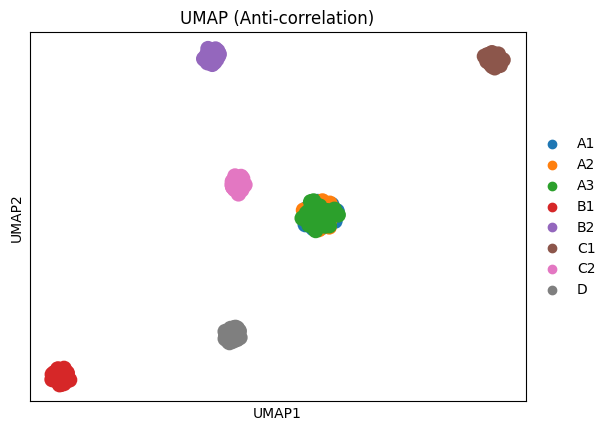

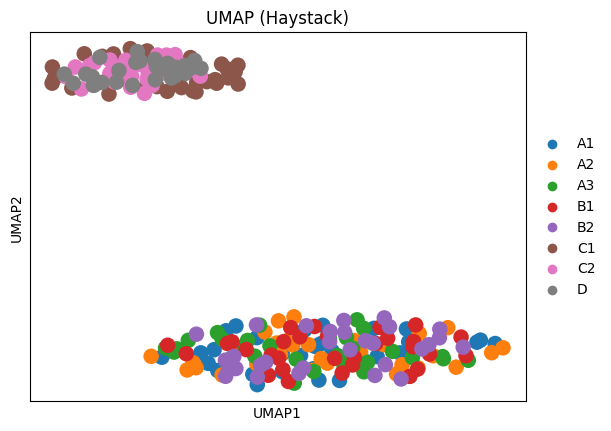

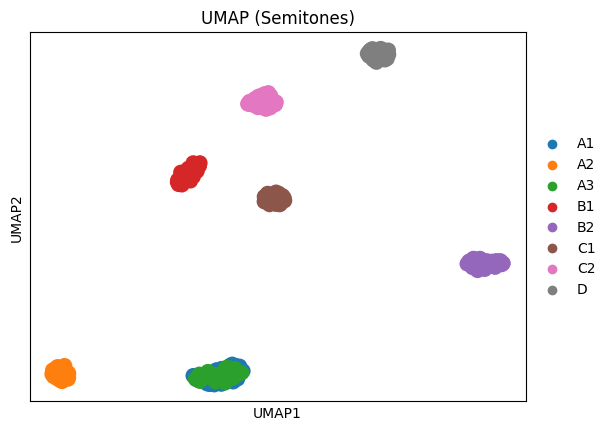

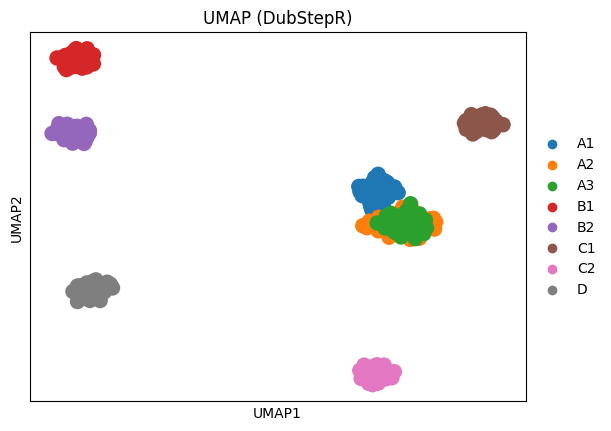

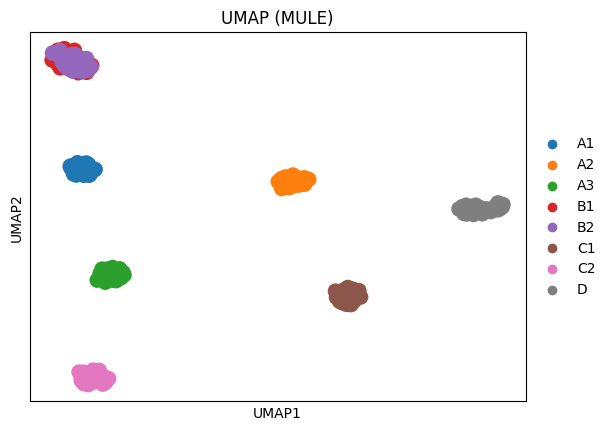

In [35]:
# method_list = ["Anti-correlation", "DubStepR"]
# results = evaluate_methods(adata, method_list)
# results['MULE'] = mule_result
plot_umap_by_method(adata, results)